In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [ ]:
train_dir = "/content/drive/MyDrive/Defungi Classification/data/train"
test_dir = "/content/drive/MyDrive/Defungi Classificaiton/data/test"

# data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 5,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.05,
    fill_mode = "nearest"
    )

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (299, 299),
    batch_size = 32,
    class_mode = "categorical",
    shuffle=True
  )

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = (299, 299),
    batch_size = 32,
    class_mode = "categorical"
  )

# weighted train
labels = train_data.classes
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weight))
print("Class weights : ", class_weight_dict)

base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=(299, 299, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(5, activation="softmax")(x)

model = Model(inputs = base_model.input, outputs = output)

model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

if __name__ == "__main__":

  history = model.fit(
    train_data,
    validation_data = test_data,
    epochs = 15,
    verbose = 1,
    class_weight = class_weight_dict
  )

  model.save("/content/drive/MyDrive/Defungi Classification/saved/inception_v3.h5")

  with open("/content/drive/MyDrive/Defungi Classification/saved/history_inception_v3.pkl", "wb") as f:
    pickle.dump(history.history, f)

Found 7290 images belonging to 5 classes.
Found 1824 images belonging to 5 classes.
Class weights :  {0: np.float64(0.7809319764327799), 1: np.float64(2.467005076142132), 2: np.float64(2.2259541984732825), 3: np.float64(2.229357798165138), 4: np.float64(0.4138518308260006)}
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 2682s 12s/step - accuracy: 0.4030 - loss: 1.3550 - val_accuracy: 0.6261 - val_loss: 0.9204
Epoch 2/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 176s 773ms/step - accuracy: 0.5746 - loss: 0.9104 - val_accuracy: 0.6683 - val_loss: 0.8331
Epoch 3/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 177s 774ms/step - accuracy: 0.6199 - loss: 0.8167 - val_accuracy: 0.6689 - val_loss: 0.8363
Epoch 4/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 179s 782ms/step - accuracy: 0.6388 - loss: 0.7781 - val_accuracy: 0.7007 - val_loss: 0.7383
Epoch 5/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 179s 785ms/step - accuracy: 0.6476 - loss: 0.7479 - val_accuracy: 0.6891 - val_loss: 0.7674
Epoch 6/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 179s 784ms/step - accuracy: 0.6539 - loss: 0.7297 - val_accuracy: 0.6859 - val_loss: 0.7872
Epoch 7/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 179s 784ms/step - accuracy: 0.6593 - loss: 0.6719 - val_accuracy: 0.7012 - val_loss: 0.7522
Epoch 8/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 179s 784ms/step - accuracy: 0.6852 - 

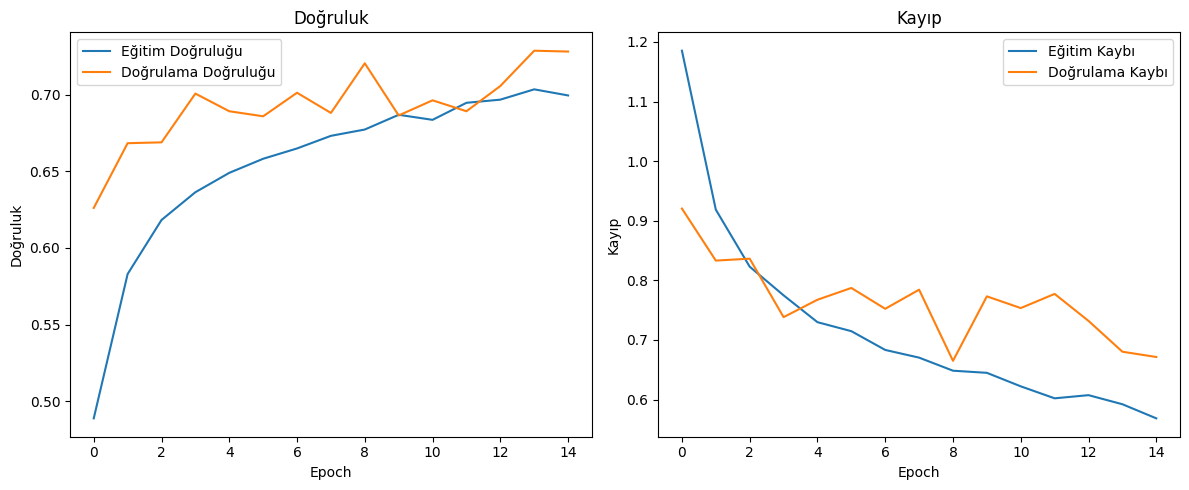

In [ ]:
with open("/content/drive/MyDrive/Defungi Classification/saved/history_inception_v3.pkl", "rb") as f:
    history_dict = pickle.load(f)

acc = history_dict["accuracy"]
vall_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
vall_loss = history_dict["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label= "Eğitim Doğruluğu")
plt.plot(epochs_range, vall_acc, label= "Doğrulama Doğruluğu")
plt.xlabel("Epoch")
plt.ylabel("Doğruluk")
plt.title("Doğruluk")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label= "Eğitim Kaybı")
plt.plot(epochs_range, vall_loss, label= "Doğrulama Kaybı")
plt.xlabel("Epoch")
plt.ylabel("Kayıp")
plt.title("Kayıp")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/Defungi Classification/saved/inception_v3.h5")

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_data = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/Defungi Classification/data/test",
    target_size = (299, 299),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False
)

Found 1824 images belonging to 5 classes.


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

class_labels = list(test_data.class_indices.keys())

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 465s 8s/step
Classification Report:
               precision    recall  f1-score   support

        BASH       0.58      0.53      0.55       467
         BBH       0.88      0.81      0.85       148
         GMA       0.53      0.78      0.63       164
         SHC       0.95      0.84      0.89       164
         TSH       0.80      0.79      0.79       881

    accuracy                           0.73      1824
   macro avg       0.75      0.75      0.74      1824
weighted avg       0.74      0.73      0.73      1824



57/57 ━━━━━━━━━━━━━━━━━━━━ 434s 8s/step


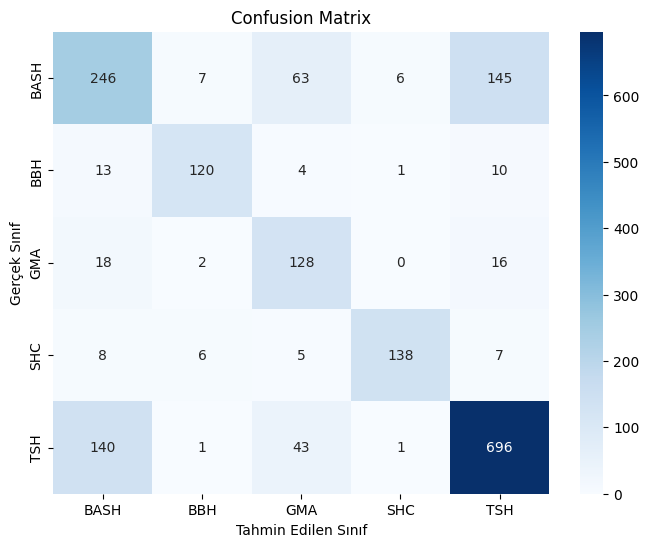

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

class_labels = list(test_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import cv2

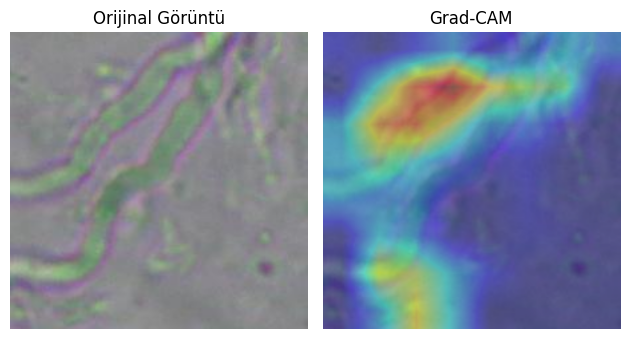

In [ ]:
img_path = "/content/drive/MyDrive/Defungi Classification/data/test/TSH/H1_101c_16.jpg"
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

last_conv_layer_name = "mixed10"

grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    pred_index = tf.argmax(predictions[0])
    class_channel = predictions[:, pred_index]

grads = tape.gradient(class_channel, conv_outputs)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

img_orig = cv2.imread(img_path)
img_orig = cv2.resize(img_orig, (299, 299))

heatmap_np = np.array(heatmap)
heatmap_np = np.maximum(heatmap_np, 0)
heatmap_np /= np.max(heatmap_np)
heatmap_resized = cv2.resize(np.uint8(255 * heatmap_np), (img_orig.shape[1], img_orig.shape[0]))
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(heatmap_color, 0.4, img_orig, 0.6, 0)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Orijinal Görüntü")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
for layer in model.layers:
    print(layer.name)

#mixed10